In [5]:

import os
import glob
import h5py
import shutil
import imgaug as aug
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sns.color_palette()
%matplotlib inline
print(os.listdir("../input"))

['chest-xray-pneumonia', 'vgg16']


In [6]:
import tensorflow as tf
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(111)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.compat.v1.set_random_seed(111)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
aug.seed(111)

In [7]:
data_dir = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray')

train_dir = data_dir / 'train'

val_dir = data_dir / 'val'

test_dir = data_dir / 'test'
print(os.listdir(test_dir))

['.DS_Store', 'PNEUMONIA', 'NORMAL']


In [8]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

train_data = []

for img in normal_cases:
    train_data.append((img,0))

for img in pneumonia_cases:
    train_data.append((img, 1))

train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.head()

,image,label
0,../input/chest-xray-pneumonia/chest_xray/chest...,0
1,../input/chest-xray-pneumonia/chest_xray/chest...,0
2,../input/chest-xray-pneumonia/chest_xray/chest...,1
3,../input/chest-xray-pneumonia/chest_xray/chest...,1
4,../input/chest-xray-pneumonia/chest_xray/chest...,1


1    3875
0    1341
Name: label, dtype: int64


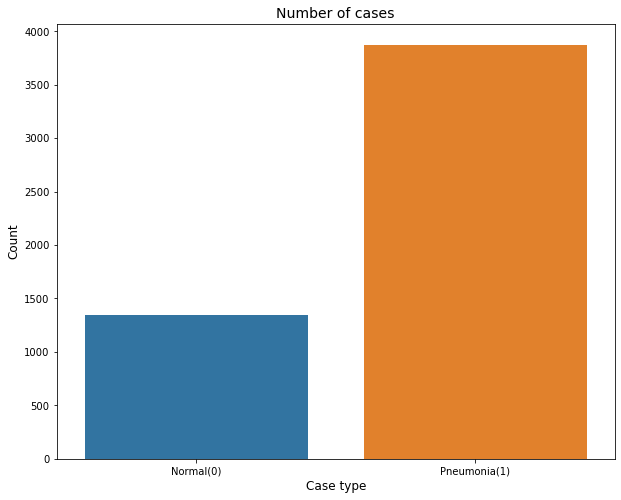

In [9]:
cases_count = train_data['label'].value_counts()
print(cases_count)

plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

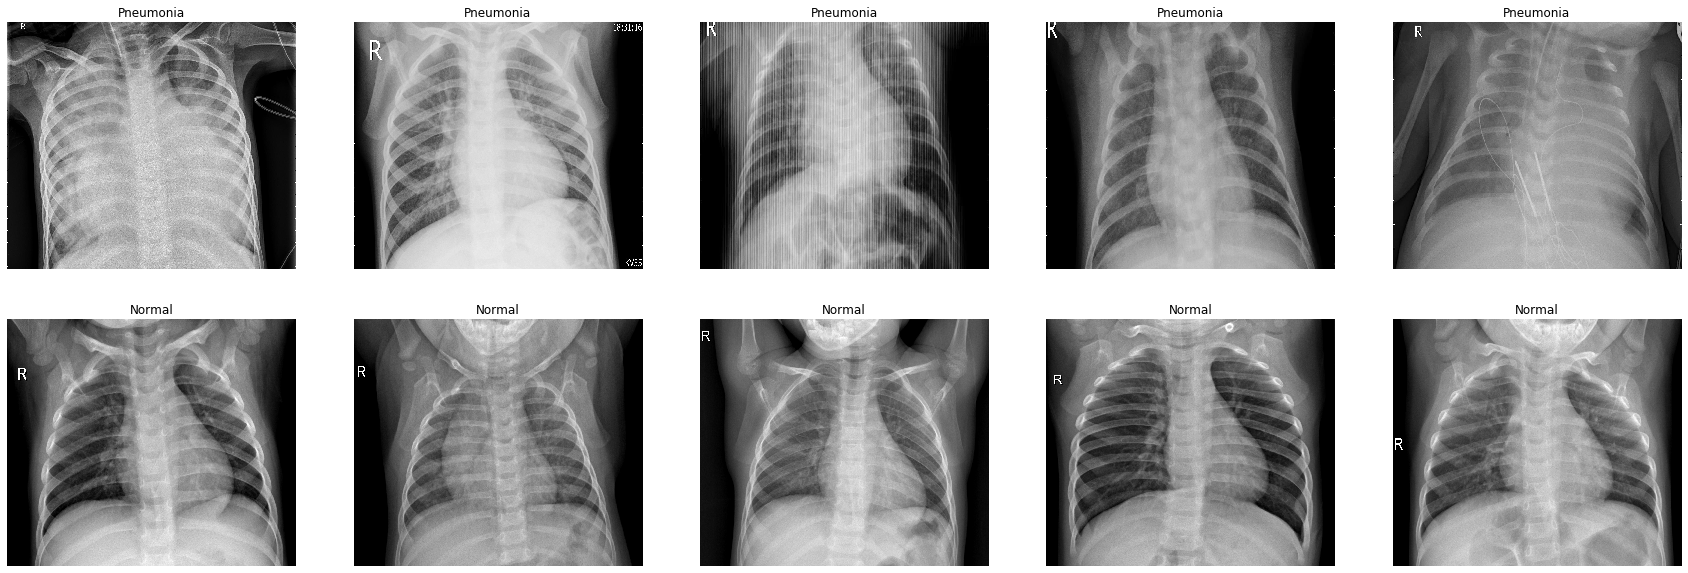

In [10]:
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

### Preparing validation data

In [11]:
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

valid_data = []
valid_labels = []



for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)

print("Total number of validation examples: ", valid_data.shape)
print("Total number of labels:", valid_labels.shape)

Total number of validation examples:  (16, 224, 224, 3)
Total number of labels: (16, 2)


## Augmentation

In [12]:
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

### Generate Traning Data

In [13]:
def data_gen(data, batch_size):
    n = len(data)
    steps = n//batch_size
    
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)

    indices = np.arange(n)
    
    i =0
    while True:
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        for j, idx in enumerate(next_batch):
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            encoded_label = to_categorical(label, num_classes=2)
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            if img.shape[2]==1:
                img = np.dstack([img, img, img])
            
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            if label==0 and count < batch_size-2:
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [14]:
def build_model():
    input_img = Input(shape=(224,224,3), name='ImageInput')
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_1')(input_img)
    x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1_2')(x)
    x = MaxPooling2D((2,2), name='pool1')(x)
    
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_1')(x)
    x = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='Conv2_2')(x)
    x = MaxPooling2D((2,2), name='pool2')(x)
    
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_1')(x)
    x = BatchNormalization(name='bn1')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='Conv3_3')(x)
    x = MaxPooling2D((2,2), name='pool3')(x)
    
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_1')(x)
    x = BatchNormalization(name='bn3')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_2')(x)
    x = BatchNormalization(name='bn4')(x)
    x = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='Conv4_3')(x)
    x = MaxPooling2D((2,2), name='pool4')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(0.7, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)
    x = Dense(2, activation='softmax', name='fc3')(x)
    
    model = Model(inputs=input_img, outputs=x)
    return model

In [15]:
model =  build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [16]:
f = h5py.File('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')


w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()    

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ImageInput (InputLayer)      (None, 224, 224, 3)       0         
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
Conv2_1 (SeparableConv2D)    (None, 112, 112, 128)     8896      
_________________________________________________________________
Conv2_2 (SeparableConv2D)    (None, 112, 112, 128)     17664     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [17]:
# # opt = RMSprop(lr=0.0001, decay=1e-6)
opt = Adam(lr=0.0001, decay=1e-5)
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_model_todate', save_best_only=True, save_weights_only=True)
model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer=opt)

In [18]:
batch_size = 16
nb_epochs = 20

train_data_gen = data_gen(data=train_data, batch_size=batch_size)
nb_train_steps = train_data.shape[0]//batch_size

print("Number of training and validation steps: {} and {}".format(nb_train_steps, len(valid_data)))

Number of training and validation steps: 326 and 16


In [19]:
history = model.fit_generator(train_data_gen, epochs=nb_epochs, steps_per_epoch=nb_train_steps,
                              validation_data=(valid_data, valid_labels),callbacks=[es, chkpt],
                              class_weight={0:1.0, 1:0.4})

Epoch 1/20
326/326 [==============================] - 100s 306ms/step - loss: 0.2276 - accuracy: 0.7717 - val_loss: 0.7690 - val_accuracy: 0.5000
Epoch 2/20
326/326 [==============================] - 92s 281ms/step - loss: 0.0669 - accuracy: 0.9563 - val_loss: 1.4092 - val_accuracy: 0.5000
Epoch 3/20
326/326 [==============================] - 91s 278ms/step - loss: 0.0526 - accuracy: 0.9653 - val_loss: 0.3615 - val_accuracy: 0.7500
Epoch 4/20
326/326 [==============================] - 89s 274ms/step - loss: 0.0522 - accuracy: 0.9674 - val_loss: 2.3836 - val_accuracy: 0.6250
Epoch 5/20
326/326 [==============================] - 90s 277ms/step - loss: 0.0513 - accuracy: 0.9688 - val_loss: 3.9351 - val_accuracy: 0.5625
Epoch 6/20
326/326 [==============================] - 109s 335ms/step - loss: 0.0428 - accuracy: 0.9716 - val_loss: 0.2666 - val_accuracy: 0.9375
Epoch 7/20
326/326 [==============================] - 89s 274ms/step - loss: 0.0375 - accuracy: 0.9751 - val_loss: 0.2280 - val_

In [20]:
# Load the model weights
# model.load_weights("./best_model_todate")

In [21]:
# Preparing test data
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')
test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  [[[[0.07058824 0.07058824 0.07058824]
   [0.07058824 0.07058824 0.07058824]
   [0.0627451  0.0627451  0.0627451 ]
   ...
   [0.08235294 0.08235294 0.08235294]
   [0.07843138 0.07843138 0.07843138]
   [0.08627451 0.08627451 0.08627451]]

  [[0.07058824 0.07058824 0.07058824]
   [0.05882353 0.05882353 0.05882353]
   [0.06666667 0.06666667 0.06666667]
   ...
   [0.07843138 0.07843138 0.07843138]
   [0.07450981 0.07450981 0.07450981]
   [0.07843138 0.07843138 0.07843138]]

  [[0.06666667 0.06666667 0.06666667]
   [0.06666667 0.06666667 0.06666667]
   [0.06666667 0.06666667 0.06666667]
   ...
   [0.08235294 0.08235294 0.08235294]
   [0.08235294 0.08235294 0.08235294]
   [0.07843138 0.07843138 0.07843138]]

  ...

  [[0.15686275 0.15686275 0.15686275]
   [0.12156863 0.12156863 0.12156863]
   [0.10196079 0.10196079 0.10196079]
   ...
   [0.08627451 0.08627451 0.08627451]
   [0.08235294 0.08235294 0.08235294]
   [0.08235294 0.08235294 0.08235294]]

  [[0.1686274

In [22]:
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 2s 3ms/step
Loss on test set:  1.180140259052841
Accuracy on test set:  0.7772436141967773


In [23]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds)

(624,)
[1 1 1 0 1 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 1 0 1 1 1 1 0
 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 0 1
 0 0 1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1
 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0
 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1
 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1

<Figure size 432x288 with 0 Axes>

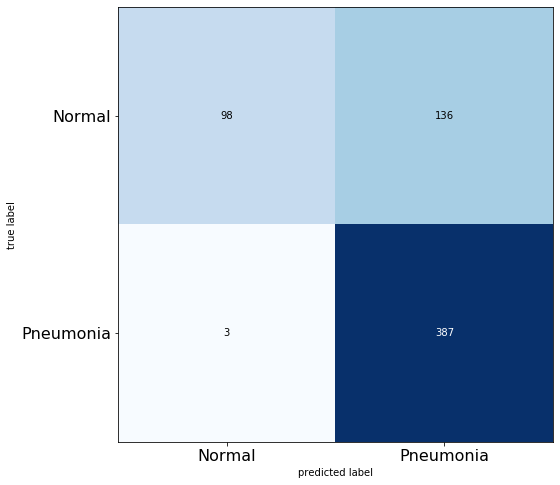

In [24]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [25]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.99
Precision of the model is 0.74
